In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn

from tqdm.auto import tqdm

In [2]:
import random


def fix_random_seed(seed=None):
    """Fix all random seeds."""
    seed = seed or random.randint(0, 14300631)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"All random seeds are set to {seed}.")

In [3]:
SEED = 14300631
fix_random_seed(SEED)

All random seeds are set to 14300631.


# Подготовка данных

In [4]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!tar -xf images.tar  # разархивируем датасет

--2022-12-17 00:27:20--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... ^C


In [4]:
# просканируем файловую систему на предмет файлов JPEG
from pathlib import Path

image_paths = sorted(Path("./Images").rglob("*.jpg"))
print(f"Found {len(image_paths)} image files.")

Found 20580 image files.


In [5]:
# для каждого файла нам нужно получить название папки, в которой он лежит - таргет
image_labels = [path.parent.name.split("-")[1] for path in image_paths]
print(f"Found {len(image_labels)} image labels, {len(np.unique(image_labels))} unique classes.")

Found 20580 image labels, 120 unique classes.


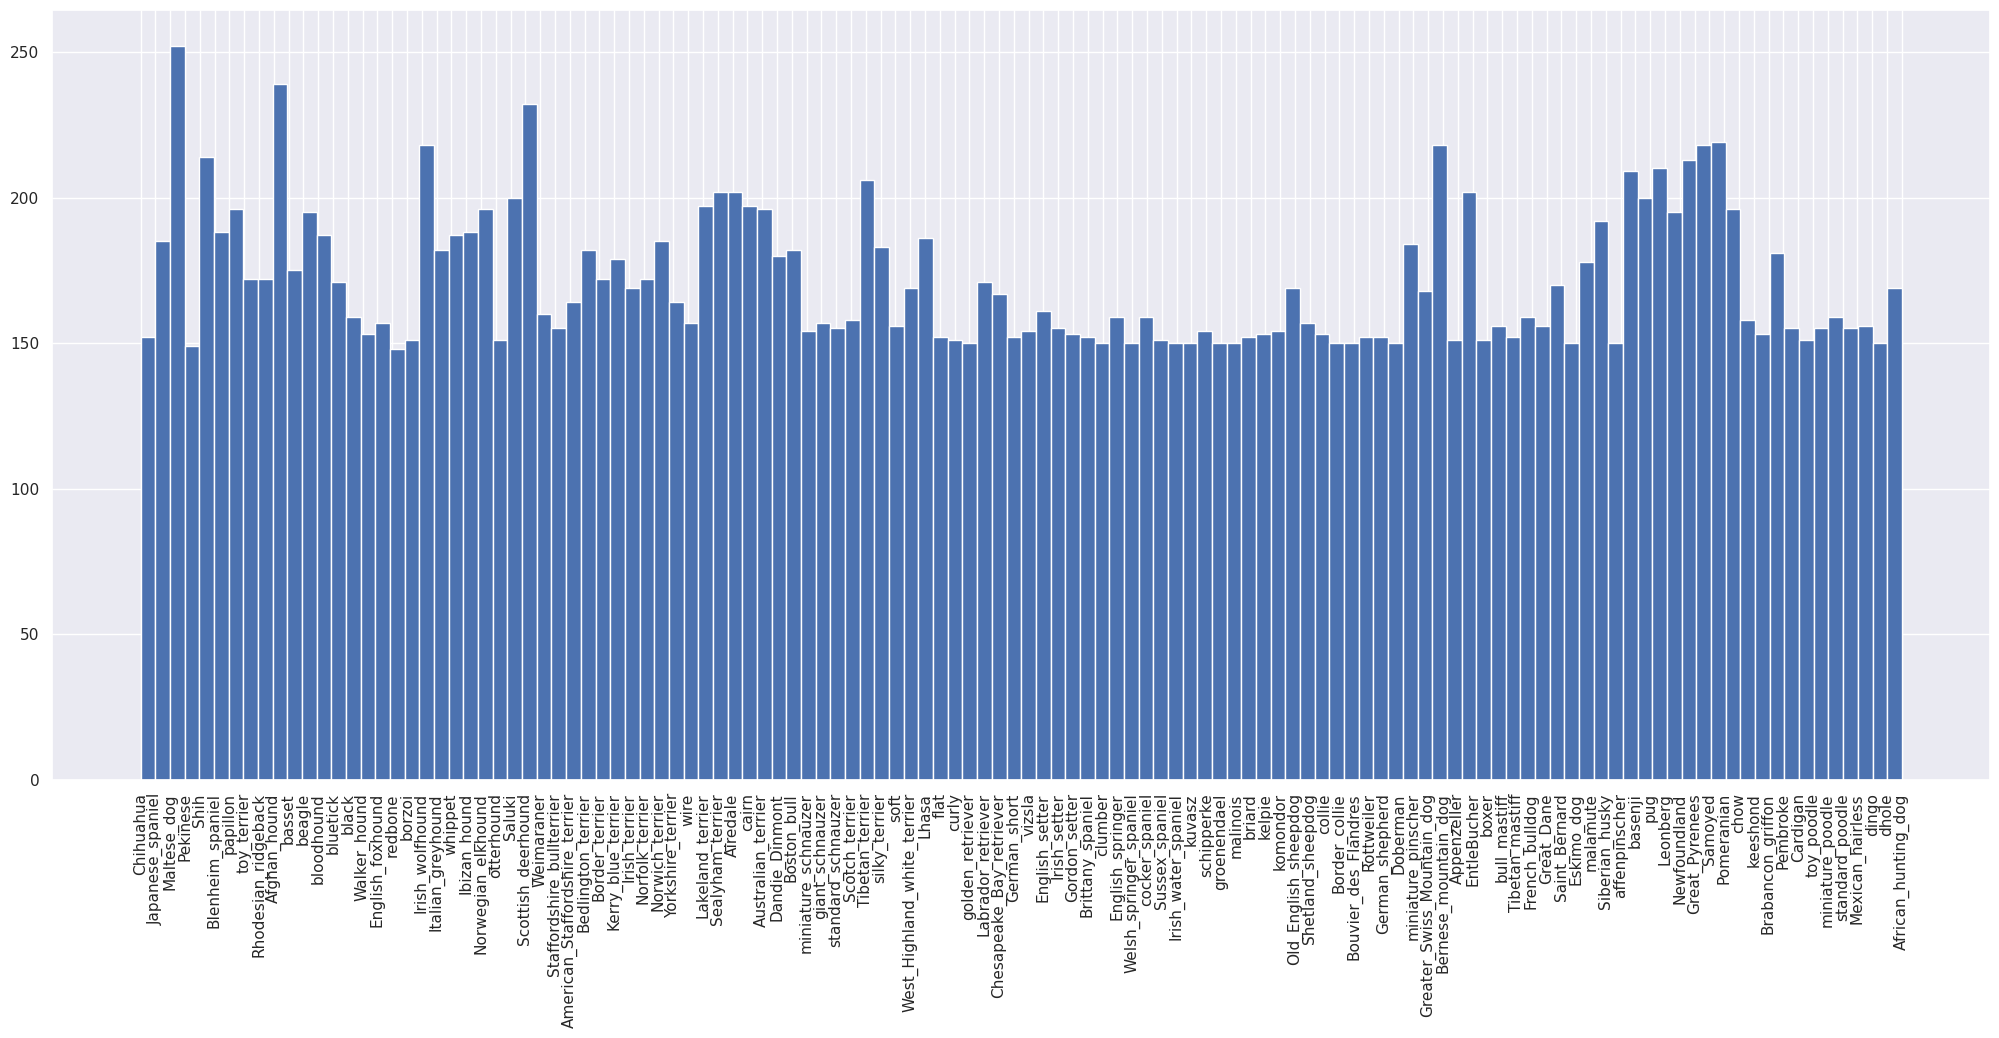

In [6]:
fig = plt.figure(figsize=(25, 10))
plt.hist(image_labels, bins=120)
plt.xticks(rotation=90)
plt.show()

In [7]:
# посмотрим на несколько случайных изображений из датасета:
from PIL import Image


def show_six_random_images(image_paths):
    random_paths = np.random.choice(image_paths, 6)
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = [ax for ax_row in axes for ax in ax_row]
    for path, ax in zip(random_paths, axes):
        with Image.open(path) as im:
            ax.imshow(np.asarray(im))
        label = path.parent.name.split("-")[1]
        ax.set_title(f"{label} [{im.width} x {im.height}]")
        # отключаем координатную сетку
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

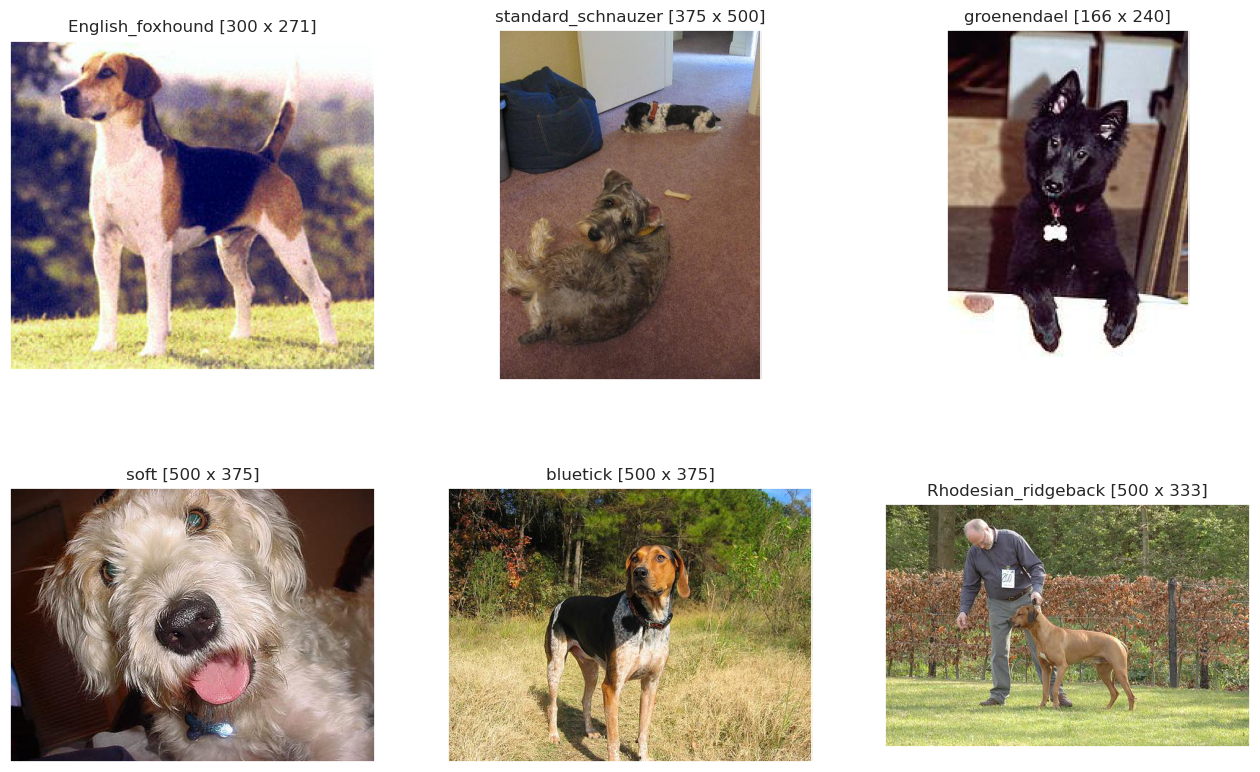

In [8]:
show_six_random_images(image_paths)

In [9]:
# нужно разделить список файлов на три выборки: тренировочную, валидационную и тестовую
from sklearn.model_selection import train_test_split


def train_val_test_split(paths, labels, val_size, test_size, seed):
    trainval_paths, test_paths, trainval_labels, _ = train_test_split(paths, labels, random_state=seed, stratify=labels, test_size=test_size)
    train_paths, val_paths = train_test_split(trainval_paths, random_state=seed, stratify=trainval_labels, test_size=val_size / (1 - test_size))
    print(f"Splitted into: {len(train_paths)} train files; {len(val_paths)} validation files; {len(test_paths)} test files.")
    return train_paths, val_paths, test_paths

In [10]:
train_paths, val_paths, test_paths = train_val_test_split(image_paths, image_labels, val_size=0.1, test_size=0.2, seed=SEED)

Splitted into: 14406 train files; 2058 validation files; 4116 test files.


In [11]:
from torch.utils.data import Dataset


# пишем кастомный датасет, который загрузит наши изображения в память,
# будет превращать их в тензоры и отдавать загрузчику
class MonkeySpeciesDataset(Dataset):
    def __init__(self, paths, transforms):
        super().__init__()
        self.paths = sorted(paths)
        self.transforms = transforms
        
        self.labels = [path.parent.name.split("-")[1] for path in self.paths]
        self.classes = np.unique(self.labels).tolist()
        self.label2id = {class_: idx for idx, class_ in enumerate(self.classes)}
        self.id2label = {idx: class_ for idx, class_ in enumerate(self.classes)}
        # загрузка изображений в память
        self.images = []
        for path in tqdm(self.paths, desc=f"Loading"):
            with Image.open(path) as im:
                if im.mode != "RGB":
                    im = im.convert("RGB")
                else:
                    im.load()
            self.images.append(im)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        sample = self.transforms(self.images[idx])
        label = self.label2id[self.labels[idx]]
        return sample, label

In [12]:
import torchvision.transforms as T

base_transforms = T.Compose([
    T.Resize(size=(224, 244)),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
trainset = MonkeySpeciesDataset(train_paths, transforms=base_transforms)
valset = MonkeySpeciesDataset(val_paths, transforms=base_transforms)

Loading:   0%|          | 0/14406 [00:00<?, ?it/s]

Loading:   0%|          | 0/2058 [00:00<?, ?it/s]

In [13]:
def show_six_random_samples(dataset):
    sample_ids = np.random.choice(len(dataset), 6)
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = [ax for ax_row in axes for ax in ax_row]
    for sample_id, ax in zip(sample_ids, axes):
        sample, label_id = dataset[sample_id]
        label = dataset.id2label[label_id]
        array = 0.5 * sample.permute(1, 2, 0).numpy() + 0.5
        ax.imshow(array)
        ax.set_title(f"{label} ({label_id = }) [{array.shape[0]} x {array.shape[1]}]")
        # отключаем координатную сетку
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

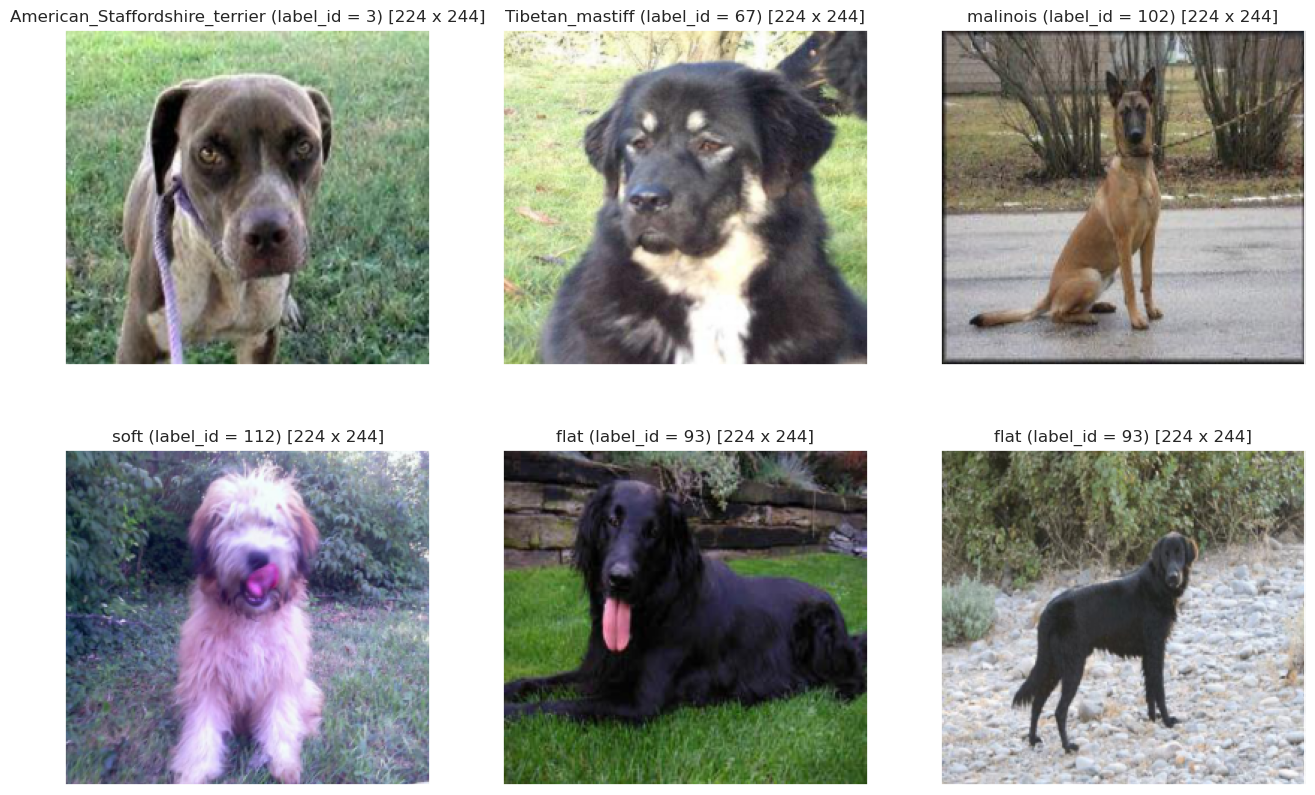

In [14]:
show_six_random_samples(trainset)

In [15]:
from sklearn.metrics import classification_report


def eval_model(model, dataloader, criterion, device, classes, make_report=False):
    model = model.to(device)
    scores, ground_truth = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            scores.append(logits)
            ground_truth.append(labels)
        scores = torch.cat(scores)
        ground_truth = torch.cat(ground_truth)
        loss = criterion(scores, ground_truth).item()

        predictions = torch.argmax(scores, dim=1)
        accuracy = (predictions == ground_truth).sum().item() / ground_truth.size(0)
    if make_report:
        predictions = predictions.cpu().numpy()
        ground_truth = ground_truth.cpu().numpy()
        report = classification_report(ground_truth, predictions, target_names=classes, zero_division=0)
    else:
        report = None
    return loss, accuracy, report

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, classes, scheduler=None):
    history = []
    model = model.to(device)
    with tqdm(total=epochs, desc='Epoch') as epoch_pbar:
        for _ in range(epochs):
            running_loss = 0
            running_corrects = 0
            running_data = 0
            model.train()
            with tqdm(total=len(train_loader), desc='Batch', leave=False) as batch_pbar:
                for batch_count, (images, labels) in enumerate(train_loader, 1):
                    images = images.to(device)
                    labels = labels.to(device)
                    # optimization part
                    optimizer.zero_grad()
                    logits = model(images)
                    loss = criterion(logits, labels)

                    loss.backward()
                    optimizer.step()
                    if scheduler is not None:
                        scheduler.step()
                    # calculate metrics
                    running_loss += loss.item()
                    predicts = torch.argmax(logits, dim=1)
                    running_data += images.size(0)
                    running_corrects += (predicts == labels).sum().item()
                    # save metrics history
                    history.append({'train_loss': loss.item(), 'train_acc': running_corrects / running_data})
                    # update progress bar
                    batch_pbar.set_postfix(loss=running_loss / batch_count, acc=running_corrects / running_data)
                    batch_pbar.update()
            val_loss, val_acc, _ = eval_model(model, val_loader, criterion, device, classes)
            history[-1]['val_loss'] = val_loss
            history[-1]['val_acc'] = val_acc
            epoch_pbar.set_postfix(
                train_loss=running_loss / len(train_loader),
                val_loss=val_loss,
                train_acc=history[-1]['train_acc'],
                val_acc=val_acc,
            )
            epoch_pbar.update()
    return pd.DataFrame(history)

In [17]:
def predict(model, dataloader, device):
    model = model.to(device)
    predictions = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc='Predicting'):
            logits = model(images.to(device))
            predictions.append(torch.argmax(logits, dim=1).cpu().numpy())
    return np.concatenate(predictions)

In [18]:
# функция принимает на вход список вида [(name_1, history_1), (name_2, history_2), ...]
def plot_experiments(experiments):
    fig, axes = plt.subplots(2, 2, figsize=(25, 13))
    axes = [ax for ax_row in axes for ax in ax_row]
    for name, history in experiments:
        for metric, ax in zip(history.columns, axes):
            marker = 'o' if metric.startswith('val_') else None
            history[metric].dropna().plot(ax=ax, label=name, marker=marker)
    for metric, ax in zip(history.columns, axes):
        ax.set_title(f'{metric} history')
        ax.set_xlabel('Iteration (batch)')
        ax.legend()
    plt.show()

In [19]:
from torch.utils.data import DataLoader


train_loader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=10, pin_memory=True)
val_loader = DataLoader(valset, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

device = torch.device('cuda:0')
criterion = nn.CrossEntropyLoss()

In [20]:
IN_CHANNELS = 3
N_CLASSES = 120
LR = 1e-3
EPOCHS = 35

In [21]:
experiments = {}  # история экспериментов

# Shallow CNN

In [22]:
model = nn.Sequential(  # размерность входа: (3 x 224 x 224)
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=8, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (8 x 111 x 111)
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (16 x 54 x 54)
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (32 x 26 x 26)
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (64 x 12 x 12)
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (128 x 5 x 5)
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (128 x 1 x 1)
    nn.Flatten(),
    nn.Linear(128, N_CLASSES),
)

In [23]:
from torchsummary import summary


print(summary(model, input_size=(3, 224, 224), device='cpu'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,168
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 32, 52, 52]           4,640
              ReLU-8           [-1, 32, 52, 52]               0
         MaxPool2d-9           [-1, 32, 26, 26]               0
           Conv2d-10           [-1, 64, 24, 24]          18,496
             ReLU-11           [-1, 64, 24, 24]               0
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13          [-1, 128, 10, 10]          73,856
             ReLU-14          [-1, 128,

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
experiments['6conv'] = train_model(model, train_loader, val_loader, criterion, optimizer=optimizer, epochs=EPOCHS, device=device, classes=trainset.classes)

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

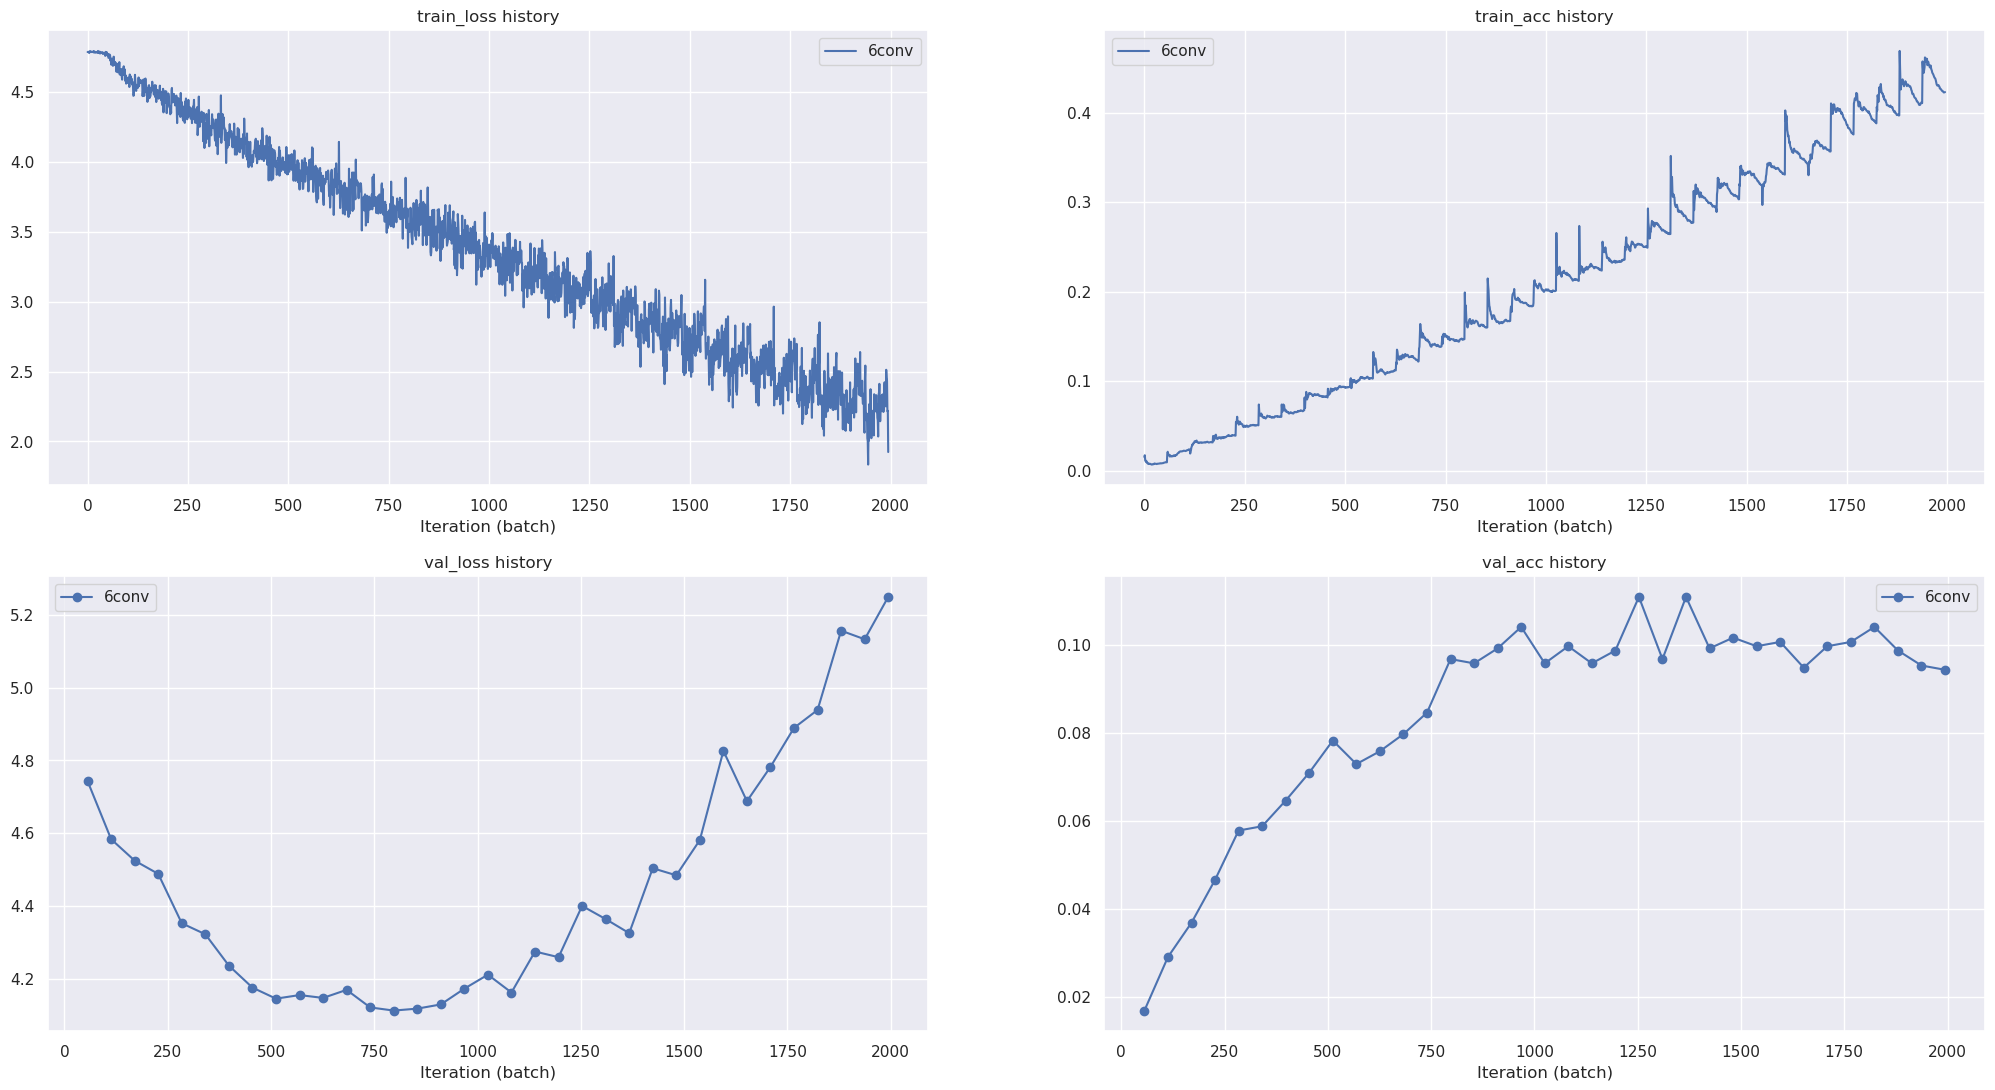

In [25]:
plot_experiments(experiments.items())

# Dropout

In [26]:
model = nn.Sequential(  # размерность входа: (3 x 224 x 224)
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=8, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (8 x 111 x 111)
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (16 x 54 x 54)
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (32 x 26 x 26)
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (64 x 12 x 12)
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (128 x 5 x 5)
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (128 x 1 x 1)
    nn.Flatten(),
    nn.Dropout(p=0.4),
    nn.Linear(128, N_CLASSES),
)
print(summary(model, input_size=(3, 224, 224), device='cpu'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,168
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 32, 52, 52]           4,640
              ReLU-8           [-1, 32, 52, 52]               0
         MaxPool2d-9           [-1, 32, 26, 26]               0
           Conv2d-10           [-1, 64, 24, 24]          18,496
             ReLU-11           [-1, 64, 24, 24]               0
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13          [-1, 128, 10, 10]          73,856
             ReLU-14          [-1, 128,

In [27]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
experiments['6conv-dropout'] = train_model(model, train_loader, val_loader, criterion, optimizer=optimizer, epochs=EPOCHS, device=device, classes=trainset.classes)

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

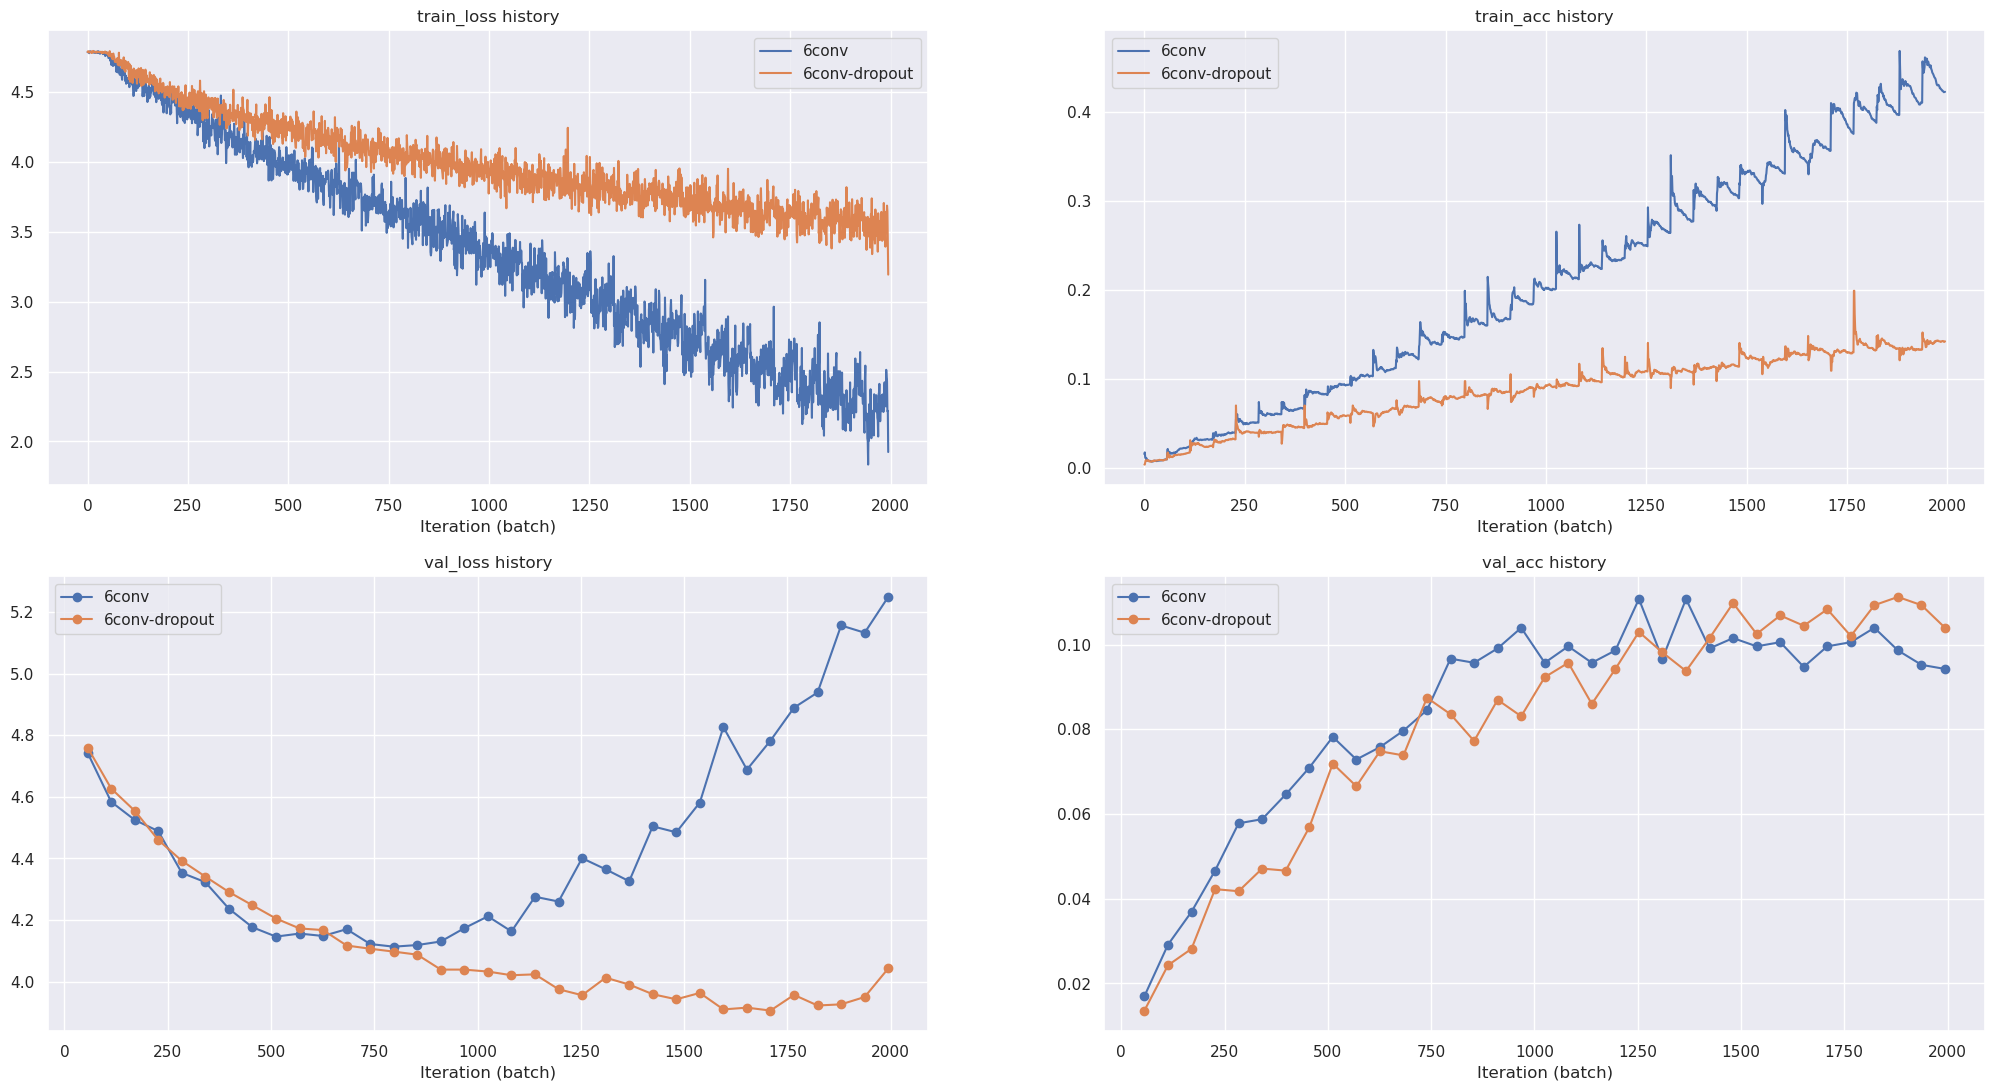

In [28]:
plot_experiments(experiments.items())

# LR scheduler

In [29]:
model = nn.Sequential(  # размерность входа: (3 x 224 x 224)
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=8, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (8 x 111 x 111)
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (16 x 54 x 54)
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (32 x 26 x 26)
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (64 x 12 x 12)
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (128 x 5 x 5)
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (128 x 1 x 1)
    nn.Flatten(),
    nn.Dropout(p=0.4),
    nn.Linear(128, N_CLASSES),
)

In [30]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.2 * LR, total_steps=EPOCHS * len(train_loader))

In [31]:
experiments['6conv-dropout-lr'] = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    classes=trainset.classes,
    scheduler=scheduler,
)

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

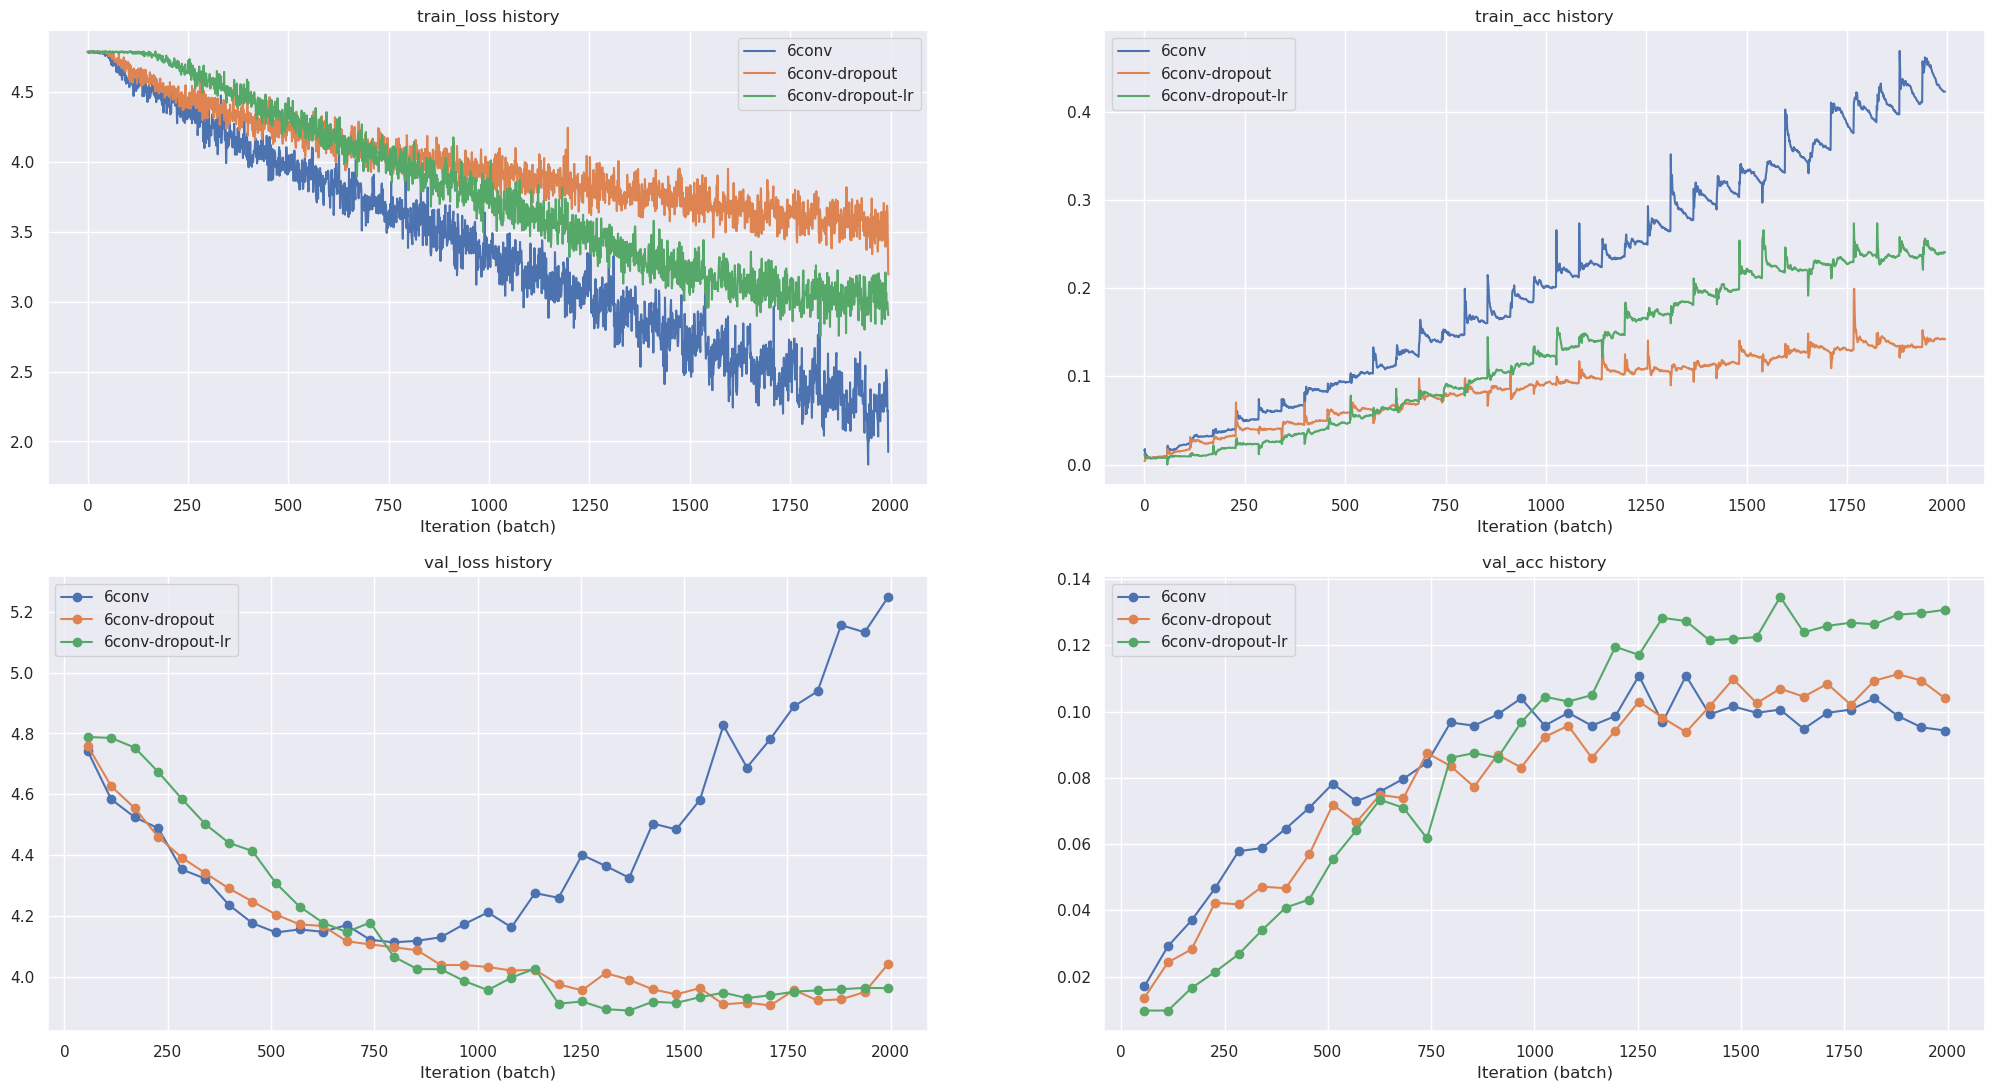

In [32]:
plot_experiments(experiments.items())

# Аугментация данных

In [35]:
# посмотрите, какие еще есть аугментации и какие у них настройки. С правильной аугментацией можно радикально увеличить качество модели
trainset.transforms = T.Compose([
    T.RandomResizedCrop(size=224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

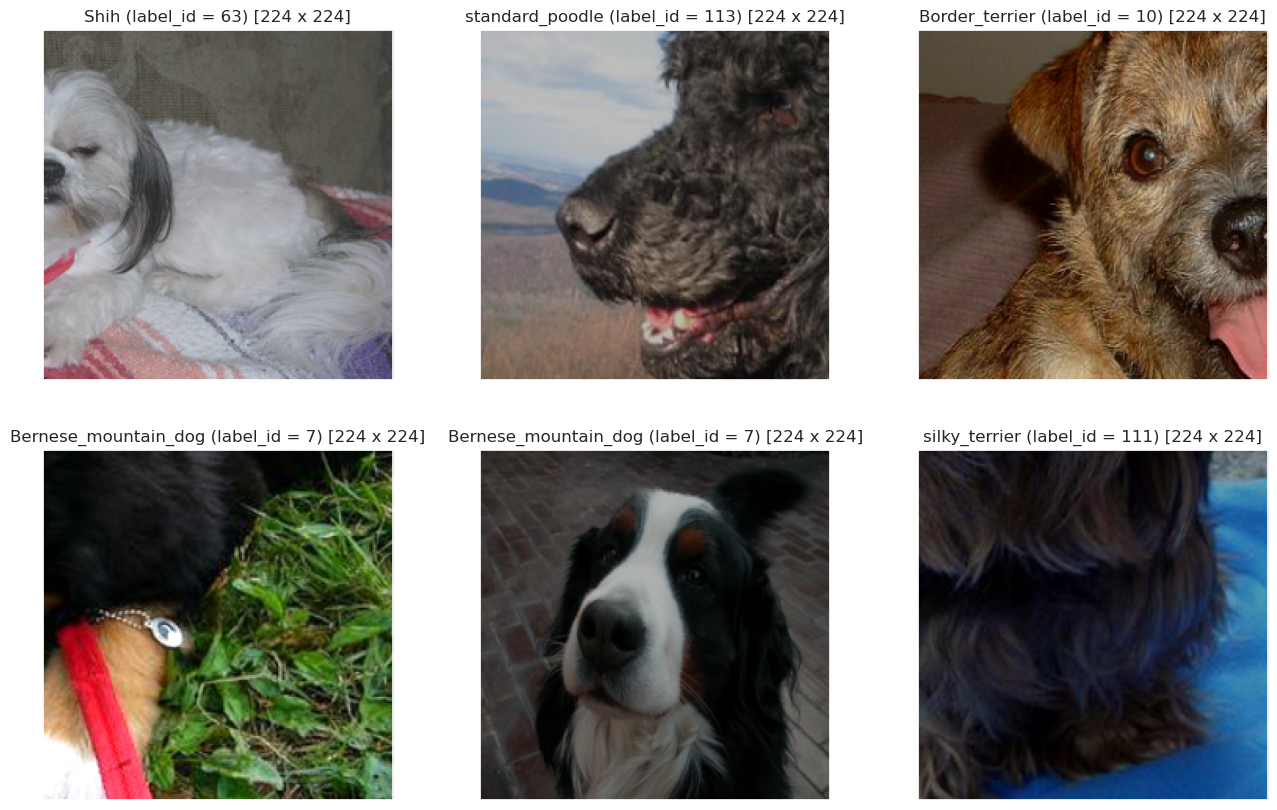

In [36]:
show_six_random_samples(trainset)

In [40]:
model = nn.Sequential(  # размерность входа: (3 x 224 x 224)
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=8, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (8 x 111 x 111)
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (16 x 54 x 54)
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (32 x 26 x 26)
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (64 x 12 x 12)
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (128 x 5 x 5)
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # (128 x 1 x 1)
    nn.Flatten(),
    nn.Dropout(p=0.4),
    nn.Linear(128, N_CLASSES),
)

In [41]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.2 * LR, total_steps=EPOCHS * len(train_loader))
experiments['6conv-dropout-lr-augs'] = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    classes=trainset.classes,
    scheduler=scheduler,
)

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

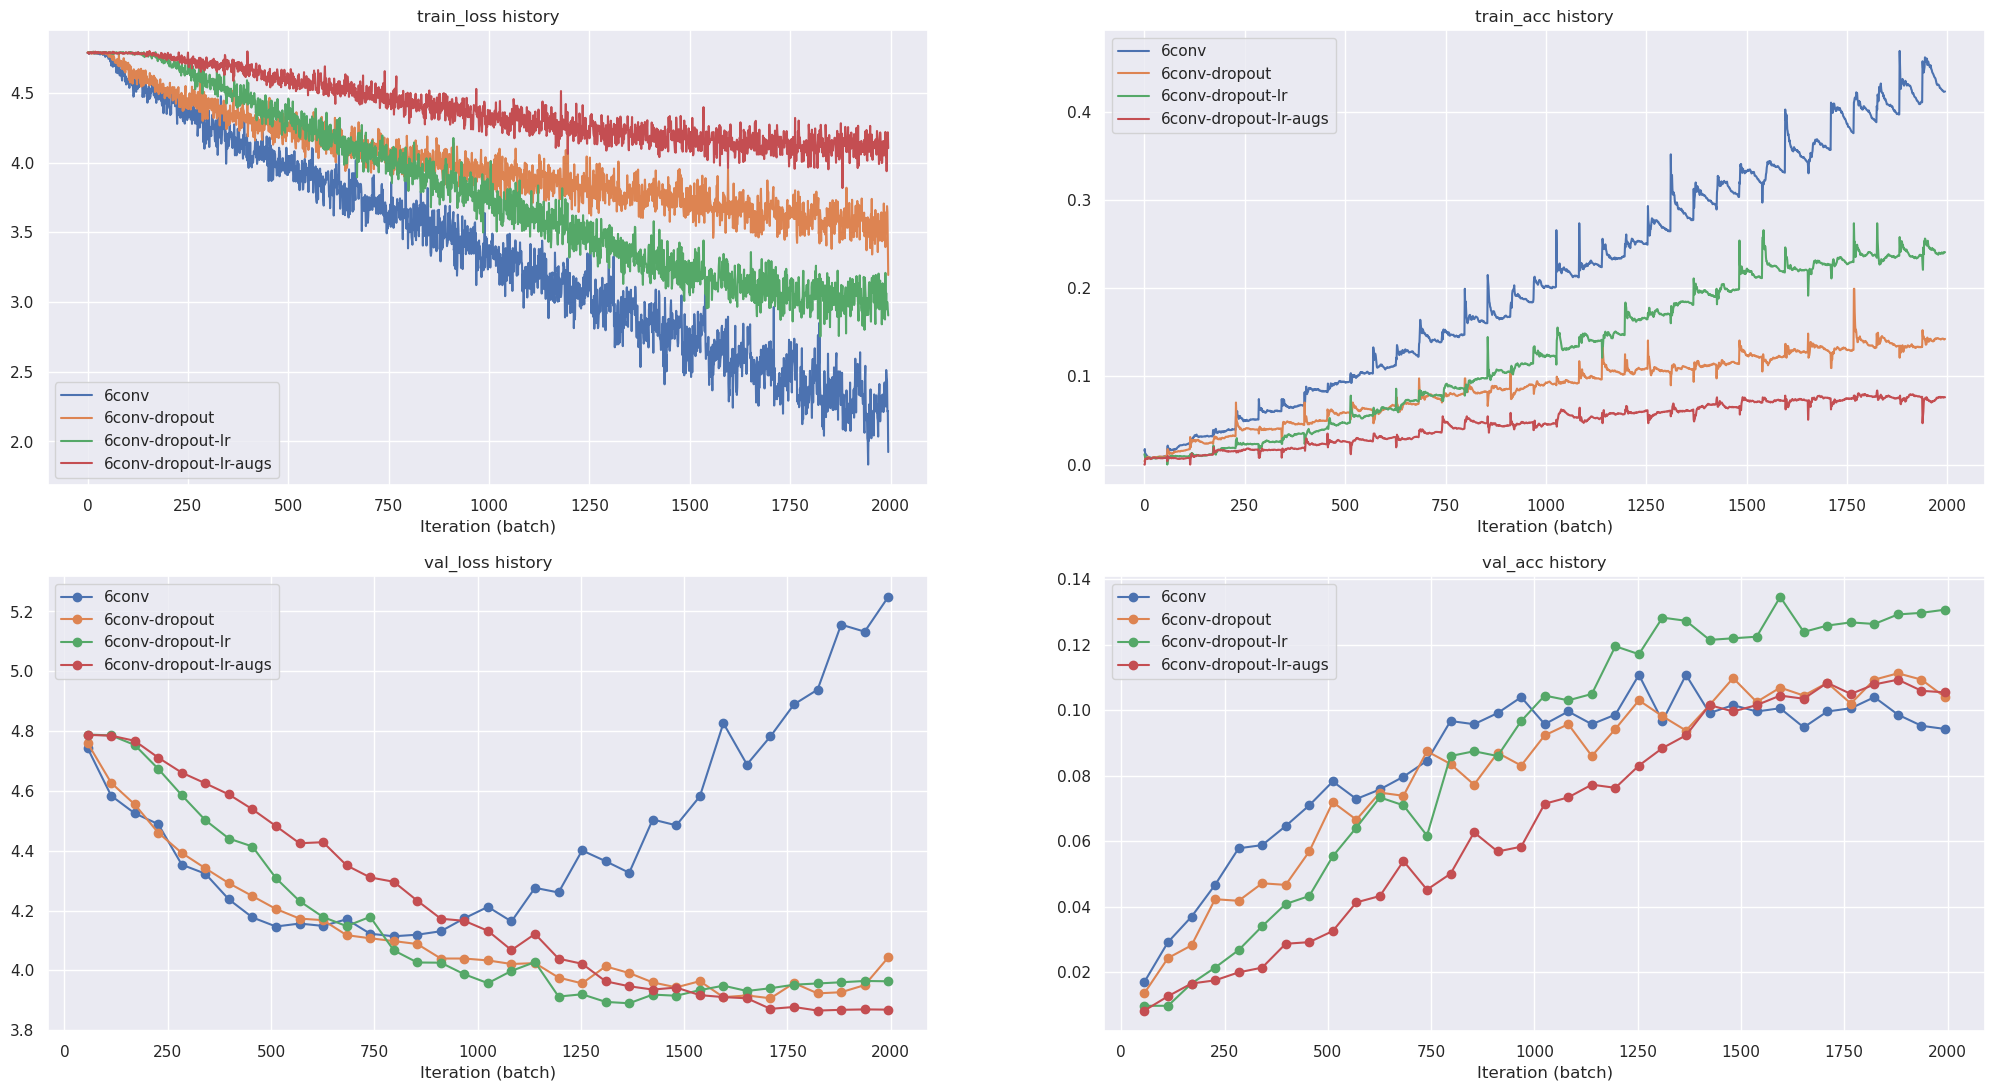

In [42]:
plot_experiments(experiments.items())

# Resnet18

In [43]:
from torchvision import models


# в модуле torchvision.models находится множество разных готовых моделей. Смотрите полный список в документации
# для продвинутых: есть отдельный пакет timm, где их еще больше. Можете попробовать разобраться сами :)
model = models.resnet18()
model.fc = nn.Linear(512, N_CLASSES)
print(summary(model, input_size=(3, 224, 224), device='cpu'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [44]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.2 * LR, total_steps=EPOCHS * len(train_loader))
experiments['resnet18'] = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    classes=trainset.classes,
    scheduler=scheduler,
)

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

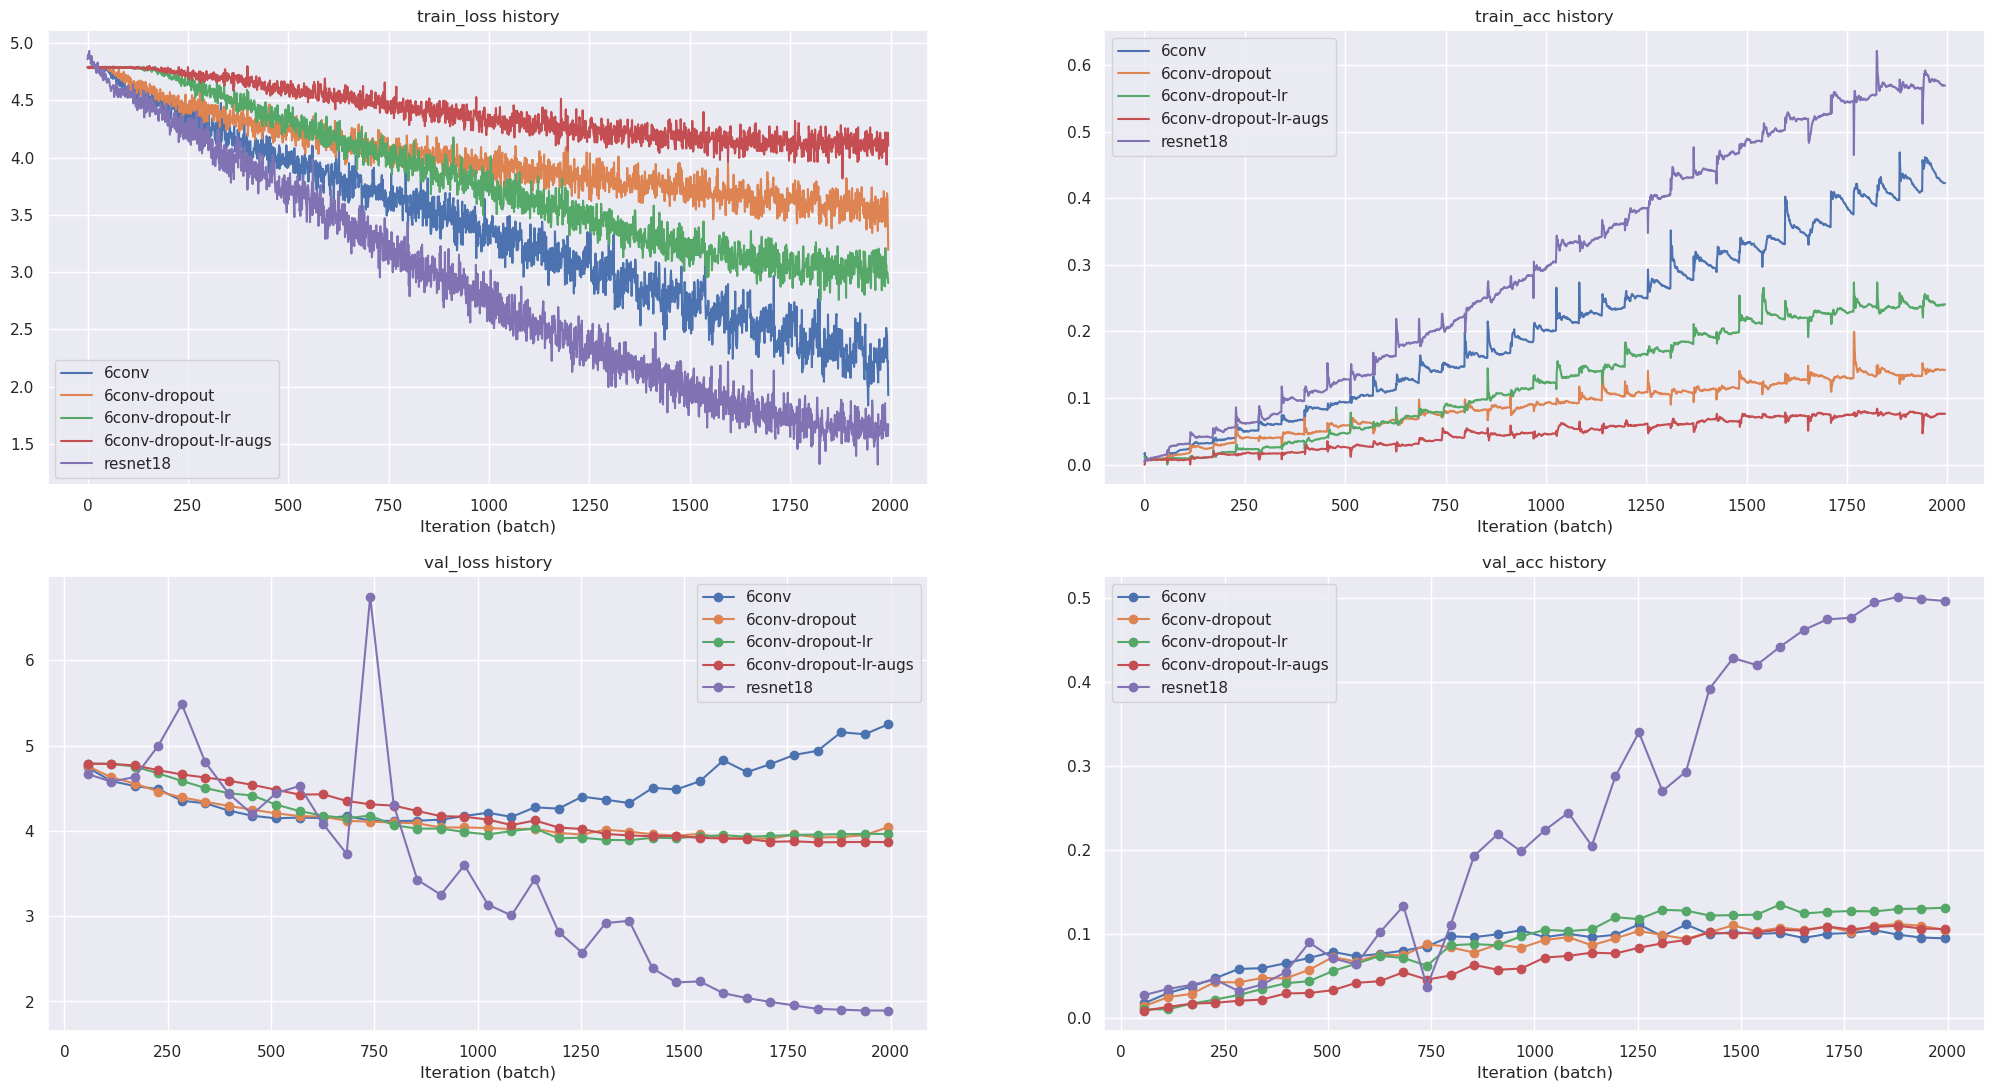

In [45]:
plot_experiments(experiments.items())

# Transfer learning

In [46]:
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(512, N_CLASSES)

trainset.transforms = T.Compose([
    T.RandomResizedCrop(size=224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
valset.transforms = T.Compose([
    T.Resize(size=(224, 244)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ybudakyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [47]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.2 * LR, total_steps=EPOCHS * len(train_loader))
experiments['resnet18-pretrained'] = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    classes=trainset.classes,
    scheduler=scheduler,
)

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

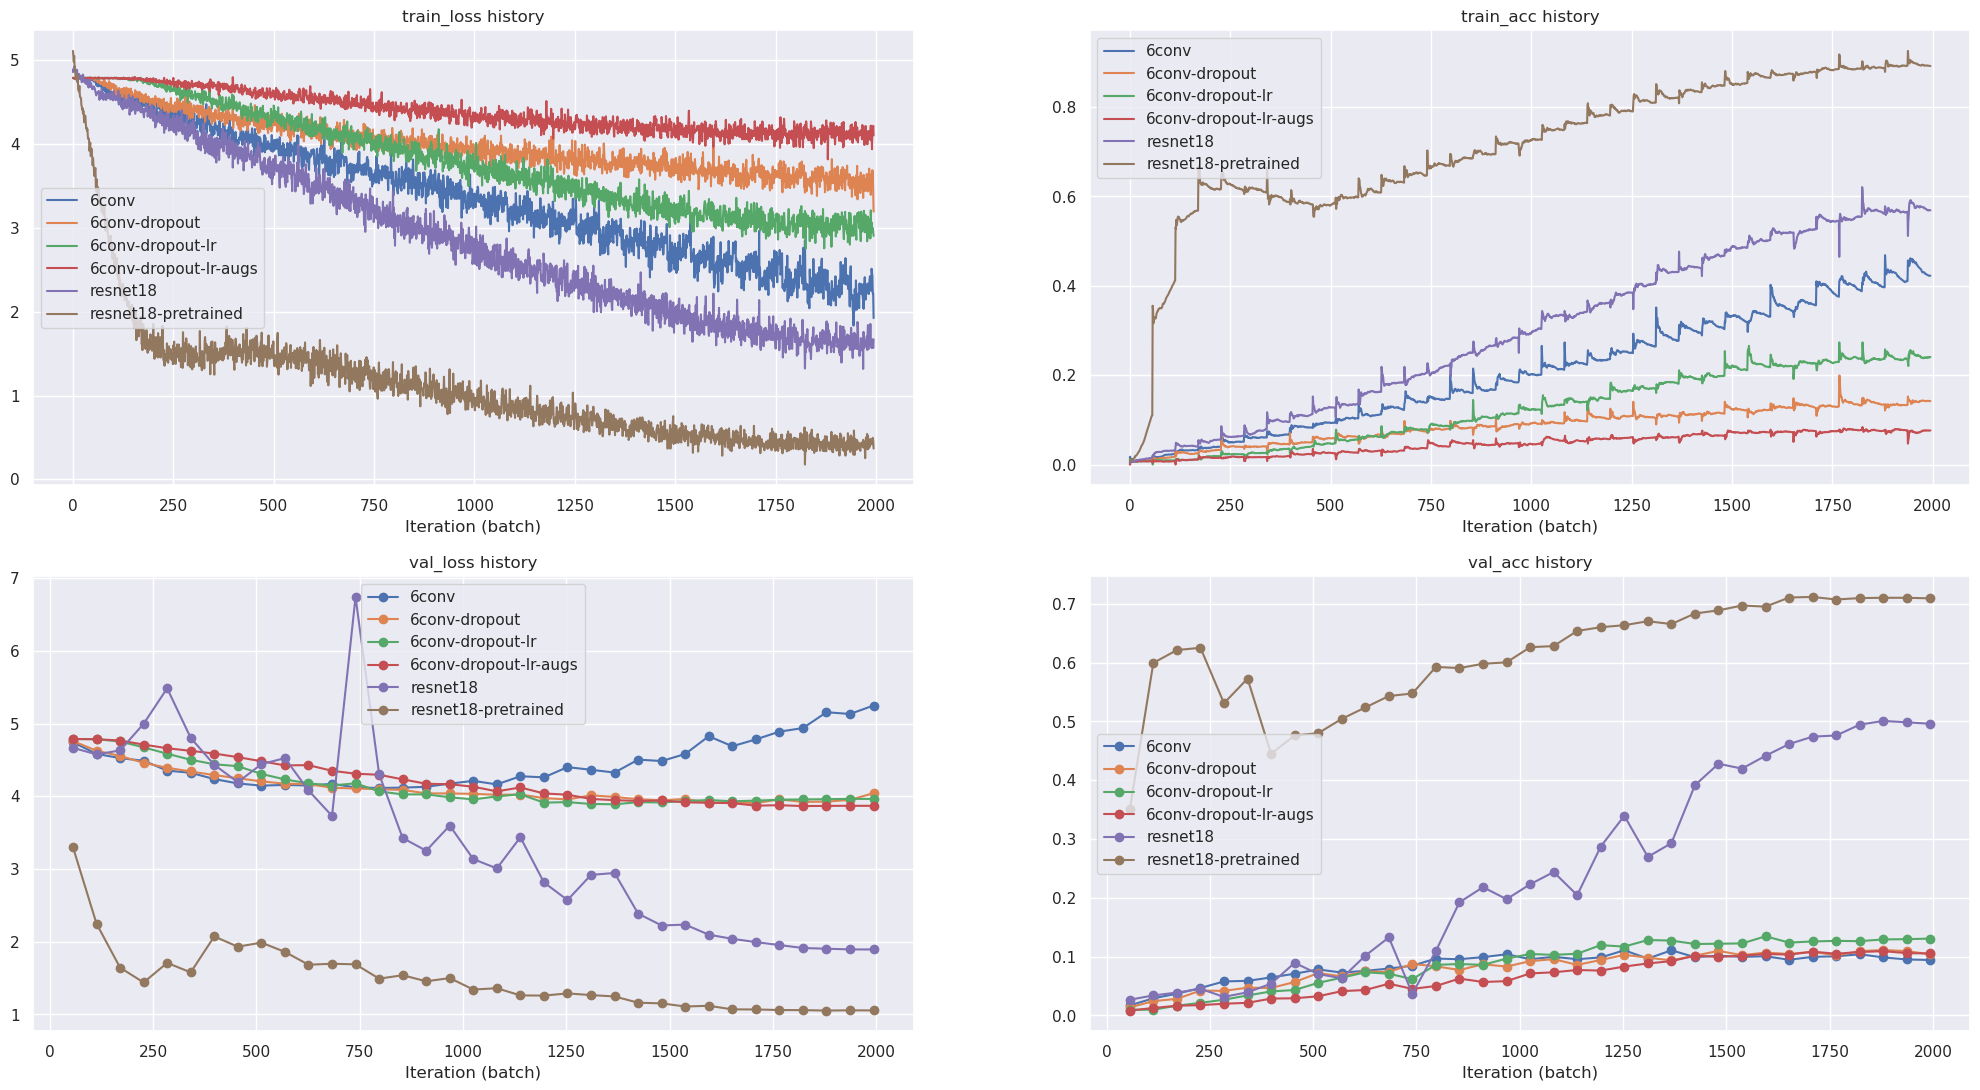

In [48]:
plot_experiments(experiments.items())

# Тестирование

In [49]:
testset = MonkeySpeciesDataset(test_paths, transforms=valset.transforms)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)
_, _, test_report = eval_model(model, test_loader, criterion, device, classes=trainset.classes, make_report=True)

Loading:   0%|          | 0/4116 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/129 [00:00<?, ?it/s]

In [50]:
print(test_report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.84      0.88      0.86        48
           African_hunting_dog       0.88      0.85      0.87        34
                      Airedale       0.71      0.88      0.79        40
American_Staffordshire_terrier       0.57      0.36      0.44        33
                   Appenzeller       0.67      0.40      0.50        30
            Australian_terrier       0.74      0.59      0.66        39
            Bedlington_terrier       0.85      0.92      0.88        36
          Bernese_mountain_dog       0.77      0.91      0.83        44
              Blenheim_spaniel       0.87      0.87      0.87        38
                 Border_collie       0.55      0.57      0.56        30
                Border_terrier       0.93      0.74      0.82        34
                   Boston_bull       0.60      0.81      0.69        36
          Bouvier_des_Flandres       0.75      0.70      0.72  